In [452]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf

In [634]:
reload(dlc_utils)
reload(utils_jjm)

<module 'python_utils_jjm' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/python_utils_jjm.py'>

In [460]:
#load and prep data
dir_path_cnmfe = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/13-Apr_17_57_40_out.mat' 
dir_path_tracking = '/volumes/My_Passport/dlc_analysis/behavcamvideos/GRIN018_H16_M13_S53/GRIN018_H16_M13_S53_dlc_tracking_foranalysis_04142020.csv'

In [463]:
C_z_scored, interpolated = utils_jjm.prepare_timedelta_dfs(dir_path_cnmfe, dir_path_tracking)

In [513]:
# plotting individual cell fluorescence 
#plt.plot(C_z_scored[20][0:4000])
#plt.show()

In [541]:
## inputs are downsampling interval, number of bins, body part to use for velocity correlation, velocity dataframe, fluorescence dataframe 
cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(2, 20, 'centroid', interpolated, C_z_scored)

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [635]:
regression_results = dlc_utils.create_regression_models_per_cell(cells_mean_C_binned_by_V, 2)

  Prob (F-statistic):
0.0179


/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


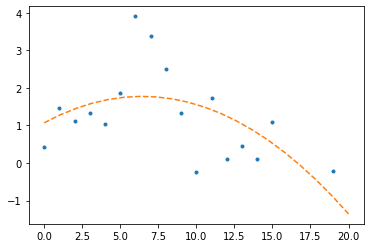

In [637]:
cell=15
#label
print(regression_results[cell]['statsmodel_results'].summary().tables[0][3][2].data)
#F-stat
print(regression_results[cell]['statsmodel_results'].summary().tables[0][3][3].data)
xp, p1d = dlc_utils.plot_cell_regression(regression_results, cell, cells_mean_C_binned_by_V)
fig = plt.plot(regression_results[cell]['fit_df']['x'].values, regression_results[cell]['fit_df']['y'].values, '.',
              xp, p1d(xp), '--')


In [640]:
F_stats = np.array([regression_results[cell]['statsmodel_results'].summary().tables[0][3][3].data for cell in range(1, len(regression_results)+1)])

In [645]:
F_stats 

array(['0.0738', ' 0.218', ' 0.181', ' 0.276', '0.00388', '0.00241',
       ' 0.576', '0.0290', '0.00242', '0.0202', '0.00159', '0.0768',
       ' 0.606', '0.0453', '0.0179', '0.00466', ' 0.198', ' 0.580',
       ' 0.398', ' 0.209', ' 0.352', ' 0.817', ' 0.175', ' 0.846',
       '0.00246', ' 0.864', '0.000143', '0.0317', ' 0.489', ' 0.433',
       '0.0123', '0.00115', ' 0.716', ' 0.104', ' 0.175', ' 0.281',
       ' 0.272', ' 0.421', ' 0.272', ' 0.190', '0.0289', '0.00647',
       ' 0.110', ' 0.117', ' 0.166'], dtype='<U8')

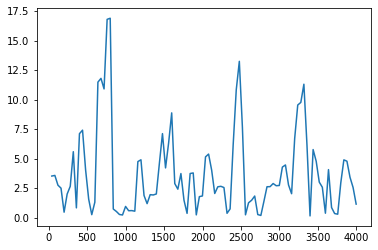

In [305]:
## plot downsampled velocity 
# plotting "interpolated velocity"
interpolated_indicies=(0,4000)
plt.plot(interpolated['msCam_index'][interpolated_indicies[0]:interpolated_indicies[1]], interpolated['tail_base'][interpolated_indicies[0]:interpolated_indicies[1]])
plt.show()

# downsample velocity and pick maximum values within 200msec 
new_sampling_interval = 2
interpolated = interpolated.set_index(pd.to_timedelta(np.linspace(0, len(interpolated)*(1/20), len(interpolated)), unit='s'), drop=True)
interpolated_downsampled = interpolated.resample(str(new_sampling_interval)+'S').max()


In [ ]:
binned_velocity = dlc_utils.bin_by_activity_threshold(interpolated['tail_base'], 40, 20, 0.5, 0.5)

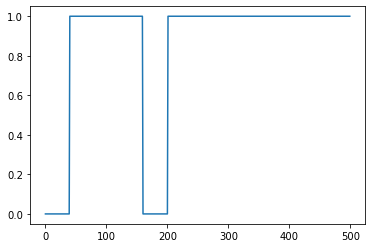

In [54]:
plt.plot(binned_velocity[indicies[0]:indicies[1]])

In [55]:
#return inidicies where velocity transitions from at least a 1 second resting period 
transition_indicies = []
resting_threshold = 40
for point in range(resting_threshold, len(binned_velocity)):
    if binned_velocity[point]>0.5 and not any(binned_velocity[point-resting_threshold:point]):
           transition_indicies.append(point)

In [51]:
#select section of trace 2 seconds around transition periods
transition_activity = {}
for index in transition_indicies:
       transition_activity[index] = C_z_scored.mean(axis=0)[index-40:index+40]
threshold_activity_df = pd.DataFrame(transition_activity)

ValueError: arrays must all be same length

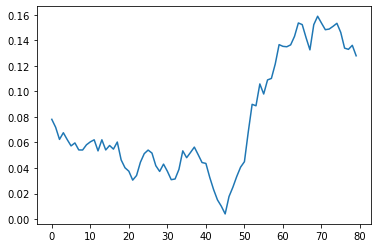

In [111]:
plt.plot(threshold_activity_df.mean(axis=1))
plt.show()

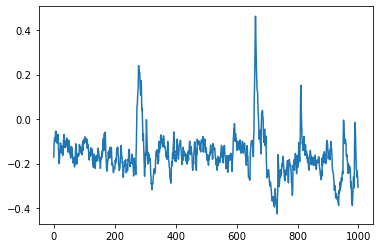

In [88]:
plt.plot(C_z_scored.mean(axis=0)[indicies[0]:indicies[1]])

In [90]:
#return indicies where value is above threshold
moving_indicies = np.argwhere(binned_velocity>0.5)
#compare df/f for moving and nonmoving periods 
df_f_moving = np.mean(C_z_scored.mean(axis=0)[moving_indicies])
df_f_resting = np.mean(C_z_scored.mean(axis=0)[np.argwhere(binned_velocity[0:25000]<0.5)])

In [92]:
np.mean(C_z_scored.mean(axis=0)[moving_indicies])

0.19100929066490835

In [94]:
np.mean(C_z_scored.mean(axis=0)[np.argwhere(binned_velocity[0:25000]<0.5)])

-0.09380713940921243